# Loading Dependencies

In [7]:
import warnings
import pkg_resources
warnings.filterwarnings('ignore')
pkg_resources.require("scipy==1.8")
pkg_resources.require("networkx==2.7")
import scipy
import networkx as nx

In [9]:
import pickle
from src.models import *
from src.utils import *
from src.utils_data import *
import multiprocess
import argparse
import time
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
from scipy.spatial.distance import squareform
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import pickle
from functools import partial
import random
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Loading the Dataset

In [ ]:
graph_size = 10
graph_type = 'ER'
num_unroll = 20
batch_size = 32

In [ ]:
data_dir = 'Saved Datasets/dataset_TrainingSet_{}nodes.pickle'.format(graph_size)
train_loader, val_loader, test_loader = data_loading(data_dir, batch_size=batch_size, train_prop=0.8)

loading data at  data/dataset_TrainingSet_10nodes.pickle
successfully loading: train 35200, val 8800, test 128, batch 32


***one data sample***

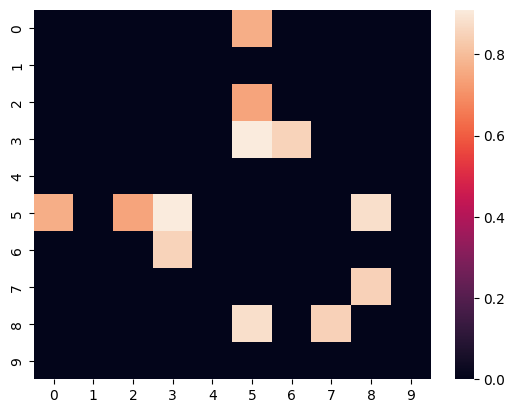

In [ ]:
for _, W in test_loader:
    eg = torch_sqaureform_to_matrix(W, device='cpu')

plt.figure()
sns.heatmap(eg[10])
plt.show()

# Training a L2G Model

## Building the Architecture

In [ ]:
n_hid = 32
n_latent = 5
n_nodeFeat = 1
n_graphFeat = 16

lr = 1e-02
lr_decay = 0.95

net = learn2graph(num_unroll, graph_size, n_hid, n_latent, n_nodeFeat, n_graphFeat).to(device)

optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = lr_scheduler.ExponentialLR(optimizer, lr_decay)

print(net)

learn2graph(
  (vae): TopoDiffVAE(
    (enc): GraphEnc(
      (conv1): GraphConvLayer()
      (conv2): GraphConvLayer()
      (fc1): Linear(in_features=64, out_features=32, bias=True)
      (fc2): Linear(in_features=32, out_features=16, bias=True)
    )
    (f_mean): Sequential(
      (0): Linear(in_features=16, out_features=5, bias=True)
    )
    (f_var): Sequential(
      (0): Linear(in_features=16, out_features=5, bias=True)
    )
    (dec): Sequential(
      (0): Linear(in_features=50, out_features=60, bias=True)
      (1): Tanh()
      (2): Linear(in_features=60, out_features=45, bias=True)
    )
  )
)


## Training Process

In [ ]:
n_epochs = 55

dur = []

epoch_train_gmse = []
epoch_val_gmse = []

for epoch in range(n_epochs):

    train_unrolling_loss, train_vae_loss, train_kl_loss, train_gmse, val_gmse = [], [], [], [], []

    t0 = time.time()

    net.train()
    for z, w_gt_batch in train_loader:
        z = z.to(device)
        w_gt_batch = w_gt_batch.to(device)
        this_batch_size = w_gt_batch.size()[0]

        optimizer.zero_grad()
        w_list, vae_loss, vae_kl, _ = net.forward(z, w_gt_batch, threshold=1e-04, kl_hyper=1)

        unrolling_loss = torch.mean(
            torch.stack([acc_loss(w_list[i, :, :], w_gt_batch[i, :], dn=0.9) for i in range(batch_size)])
        )

        loss = unrolling_loss + vae_loss
        loss.backward()
        optimizer.step()

        w_pred = w_list[:, num_unroll - 1, :]
        gmse = gmse_loss_batch_mean(w_pred, w_gt_batch)

        train_gmse.append(gmse.item())
        train_unrolling_loss.append(unrolling_loss.item())
        train_vae_loss.append(vae_loss.item())
        train_kl_loss.append(vae_kl.item())

    scheduler.step()

    net.eval()
    for z, w_gt_batch in val_loader:
        z = z.to(device)
        w_gt_batch = w_gt_batch.to(device)

        w_list = net.validation(z, threshold=1e-04)
        w_pred = torch.clamp(w_list[:, num_unroll - 1, :], min=0)
        loss = gmse_loss_batch_mean(w_pred, w_gt_batch)
        val_gmse.append(loss.item())

    dur.append(time.time() - t0)

    print("Epoch {:04d} | lr: {:04.8f} | Time(s): {:.4f}".format(epoch + 1, scheduler.get_lr()[0], np.mean(dur)))
    print("== train Loss <unroll: {:04.4f} | vae : {:04.4f} | kl : {:04.4f}>".format(np.mean(train_unrolling_loss),
                                                                                  np.mean(train_vae_loss),
                                                                                  np.mean(train_kl_loss)))
    print("== gmse <train: {:04.4f} | val: {:04.4f}> ".format(np.mean(train_gmse), np.mean(val_gmse)))
    print()
    epoch_train_gmse.append(np.mean(train_gmse))
    epoch_val_gmse.append(np.mean(val_gmse))

Epoch 0001 | lr: 0.00902500 | Time(s): 118.1654
== train Loss <unroll: 191925.2329 | vae : 76.4523 | kl : 71.3164>
== gmse <train: 129.7904 | val: 1.2256> 

Epoch 0002 | lr: 0.00857375 | Time(s): 116.5668
== train Loss <unroll: 2034.1774 | vae : 1.6538 | kl : 0.0073>
== gmse <train: 1.2912 | val: 0.8328> 

Epoch 0003 | lr: 0.00814506 | Time(s): 115.7502
== train Loss <unroll: 1773.7873 | vae : 1.6120 | kl : 0.0012>
== gmse <train: 0.8861 | val: 0.7111> 

Epoch 0004 | lr: 0.00773781 | Time(s): 115.3769
== train Loss <unroll: 1436.1604 | vae : 1.6413 | kl : 0.0005>
== gmse <train: 0.7435 | val: 0.6635> 

Epoch 0005 | lr: 0.00735092 | Time(s): 115.6499
== train Loss <unroll: 1062.0911 | vae : 1.6605 | kl : 0.0003>
== gmse <train: 0.6877 | val: 0.6200> 

Epoch 0006 | lr: 0.00698337 | Time(s): 115.1416
== train Loss <unroll: 721.1594 | vae : 1.6299 | kl : 0.0002>
== gmse <train: 0.6368 | val: 0.6032> 

Epoch 0007 | lr: 0.00663420 | Time(s): 115.2262
== train Loss <unroll: 443.2827 | vae : 1

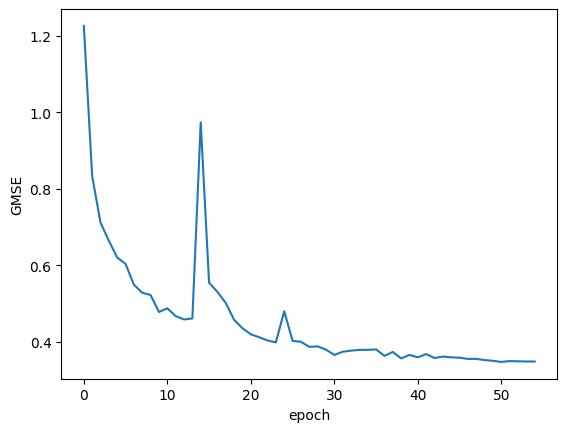

In [ ]:
plt.figure()
plt.plot(epoch_val_gmse)
plt.ylabel('GMSE')
plt.xlabel('epoch')
plt.title('validation loss')
plt.show()

## Saving the Trained Model

In [ ]:
save_path = 'Saved Models/RL2G_{}_unroll{}.pt'.format(graph_size, num_unroll)

torch.save({'net_state_dict': net.state_dict(),
            'optimiser_state_dict': optimizer.state_dict()
            }, save_path)


print('model saved at: {}'.format(save_path))

model saved at: saved_model/RL2G_10_unroll20.pt


# Testing the Model

In [ ]:
for z, w_gt_batch in test_loader:
    test_loss = []
    z = z.to(device)

    w_gt_batch = w_gt_batch.to(device)
    this_batch_size = w_gt_batch.size()[0]

    adj_batch = w_gt_batch.clone()
    adj_batch[adj_batch > 0] = 1
    w_list = net.validation(z, threshold=1e-04)
    w_pred = torch.clamp(w_list[:, num_unroll - 1, :], min=0)

    loss_mean = gmse_loss_batch_mean(w_pred, w_gt_batch)
    loss_pred = gmse_loss_batch(w_pred, w_gt_batch)

    layer_loss_batch = torch.stack([layerwise_gmse_loss(w_list[i, :, :], w_gt_batch[i, :]) for i in range(batch_size)])


loss_all_data = loss_pred.detach().cpu().numpy()
final_pred_loss, final_pred_loss_ci, _, _ = mean_confidence_interval(loss_all_data, 0.95)
print('GMSE: {} +- {}'.format(final_pred_loss, final_pred_loss_ci))

aps_auc = binary_metrics_batch(adj_batch, w_pred, device)
print('aps: {} +- {}'.format(aps_auc['aps_mean'], aps_auc['aps_ci']))
print('auc: {} +- {}'.format(aps_auc['auc_mean'], aps_auc['auc_ci']))

layer_loss_mean = [mean_confidence_interval(layer_loss_batch[:,i].detach().cpu().numpy(), confidence=0.95)[0] for i in range(num_unroll)]
layer_loss_mean_ci = [mean_confidence_interval(layer_loss_batch[:,i].detach().cpu().numpy(), confidence=0.95)[1] for i in range(num_unroll)]
print('layerwise test loss :{}'.format(layer_loss_mean))

GMSE: 0.28413787484169006 +- 0.04259291259985595
aps: 0.8595601539276725 +- 0.03906178617180645
auc: nan +- nan
layerwise test loss :[1.0004015, 1.0700557, 1.1677037, 1.2746375, 1.4351623, 1.6044086, 1.773748, 1.9820874, 2.1257217, 2.2382731, 2.58778, 1.411388, 1.2943535, 0.86767685, 0.7339287, 1.0831317, 0.6339978, 0.63436884, 0.60047185, 0.31888157]


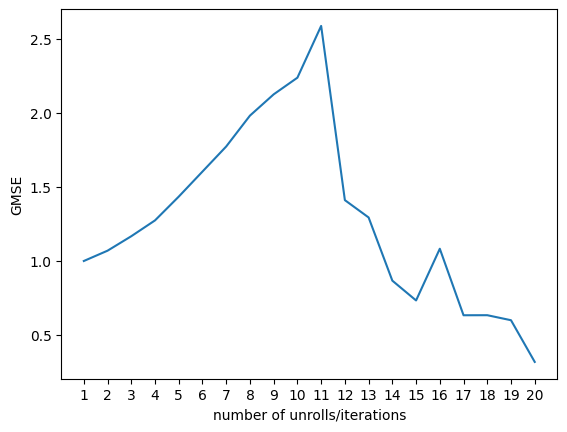

In [ ]:
plt.figure()
plt.plot(np.arange(1,num_unroll+1,1), layer_loss_mean)
plt.xticks(np.arange(1,num_unroll+1,1))
plt.ylabel('GMSE')
plt.xlabel('number of unrolls/iterations')
plt.show()

## Test 1

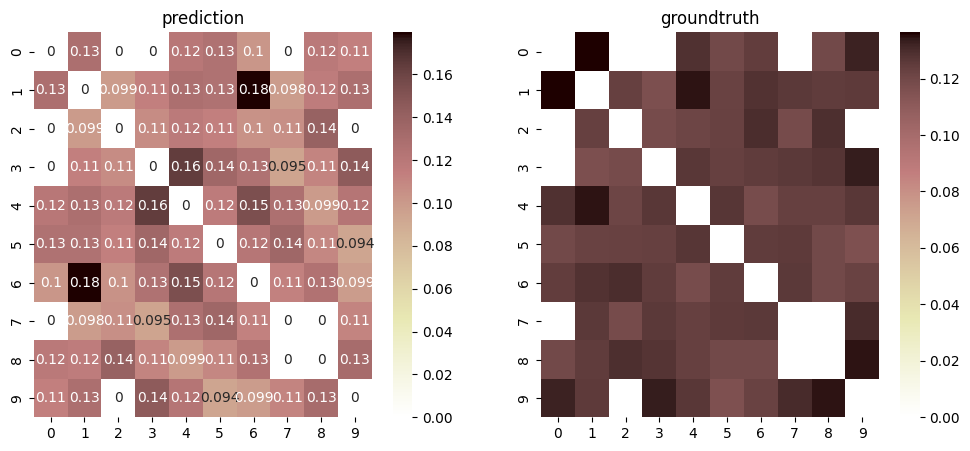

In [ ]:
idx = 3
temp1 = w_pred[idx,:].detach().cpu().numpy()
temp2 = w_gt_batch[idx,:].detach().cpu().numpy()
threshold = 0.07

for i in range(len(temp1)):
    if temp1[i]<=threshold:
        temp1[i]=0

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(squareform(temp1), cmap = 'pink_r',  ax=axs[0], annot= True)
axs[0].set_title('prediction')
sns.heatmap(squareform(temp2), cmap = 'pink_r', ax=axs[1])
axs[1].set_title('groundtruth')
plt.show()

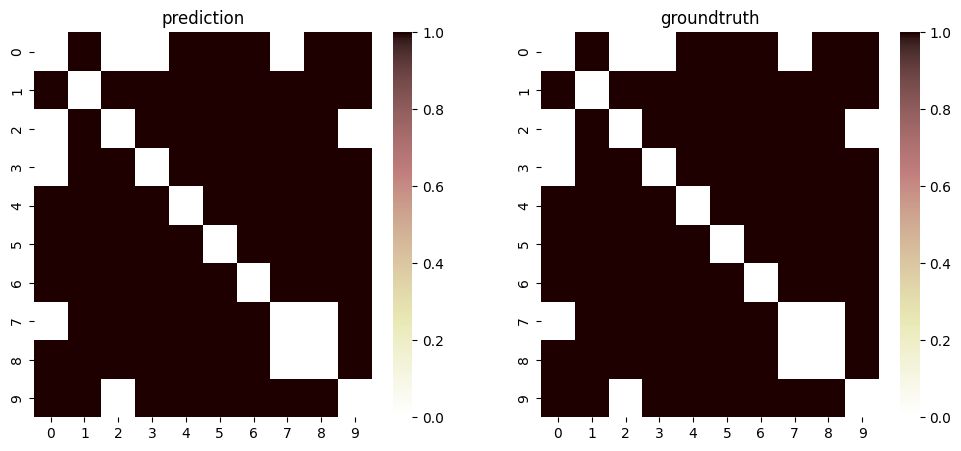

In [ ]:
for i in range(len(temp1)):
    if temp1[i]>=threshold:
        temp1[i]=1

for i in range(len(temp1)):
    if temp2[i]>0:
        temp2[i]=1

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(squareform(temp1), cmap = 'pink_r', ax=axs[0])
axs[0].set_title('prediction')
sns.heatmap(squareform(temp2), cmap = 'pink_r', ax=axs[1])
axs[1].set_title('groundtruth')
plt.show()

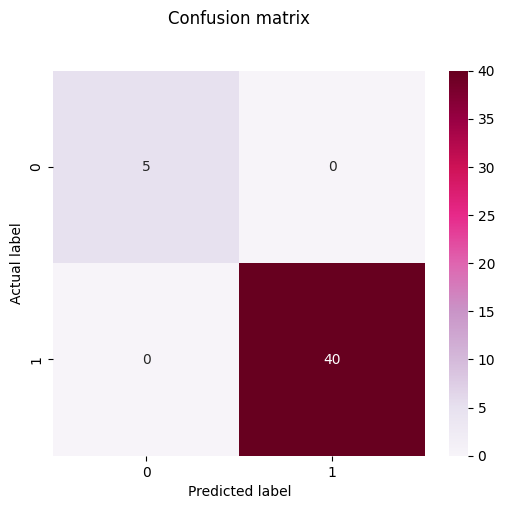

In [ ]:
f, ax = plt.subplots(figsize=(6,5))
cm = confusion_matrix(temp1, temp2)
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="PuRd" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

In [ ]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
FPP = FP/(FP+TN)
FNP = FN/(TP+FN)
ACC = (TP+TN)/(TP+FP+FN+TN)

print('False Positive Proportion: ', FPP)
print('False Negative Proportion: ', FNP)
print('Sensitivity: \t', Sensitivity)
print('Specificity: \t', Specificity)
print('Accuracy: \t', ACC)

False Positive Proportion:  0.0
False Negative Proportion:  0.0
Sensitivity: 	 1.0
Specificity: 	 1.0
Accuracy: 	 1.0


## Test 2

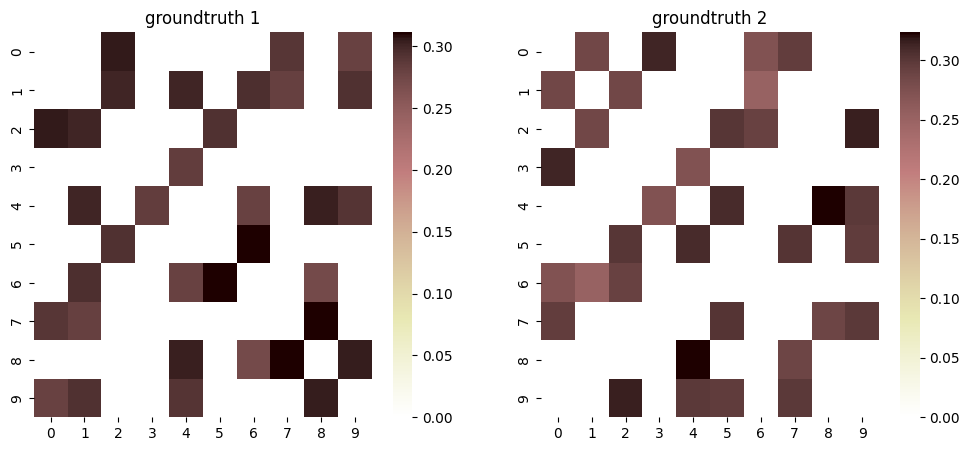

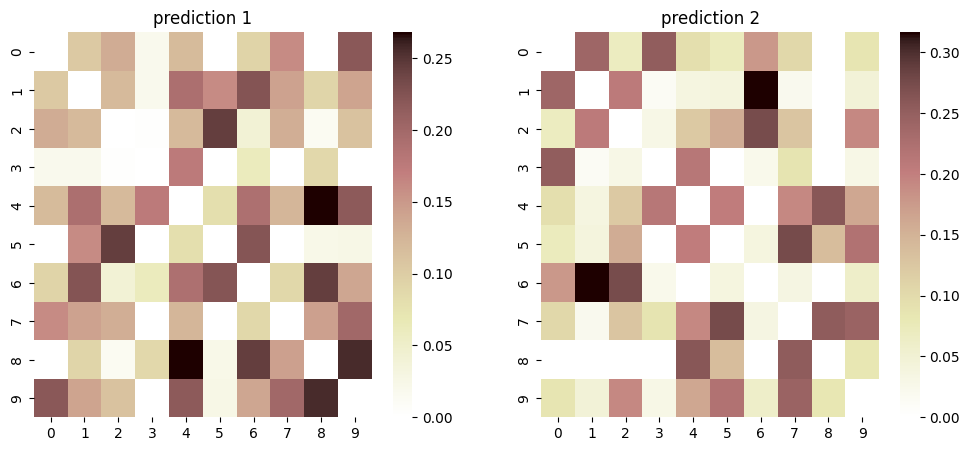

In [ ]:
idx1 = 25
idx2 = 46

temp1 = w_gt_batch[idx1,:].detach().cpu().numpy()
temp2 = w_gt_batch[idx2,:].detach().cpu().numpy()

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(squareform(temp1), cmap = 'pink_r', ax=axs[0])
axs[0].set_title('groundtruth 1')
sns.heatmap(squareform(temp2), cmap = 'pink_r', ax=axs[1])
axs[1].set_title('groundtruth 2')
plt.show()

print()

temp1 = w_pred[idx1,:].detach().cpu().numpy()
temp2 = w_pred[idx2,:].detach().cpu().numpy()

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(squareform(temp1), cmap = 'pink_r', ax=axs[0])
axs[0].set_title('prediction 1')
sns.heatmap(squareform(temp2), cmap = 'pink_r', ax=axs[1])
axs[1].set_title('prediction 2')
plt.show()

## Test 3

In [ ]:
graph1_type = 'WS'
edge1_type = 'lognormal'
graph1_size = 4
graph1_hyper = {'k': 3, 'p': 0.4}

graph2_type = 'WS'
edge2_type = 'gaussian'
graph2_size = 6
graph2_hyper = {'m': 4}

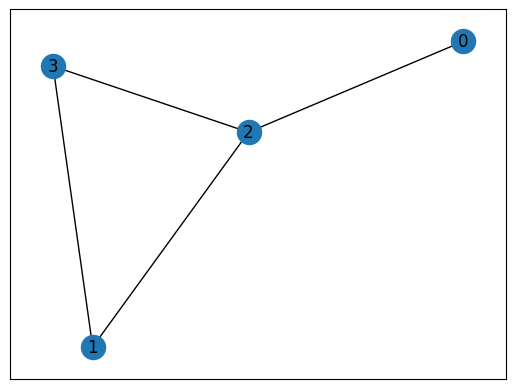

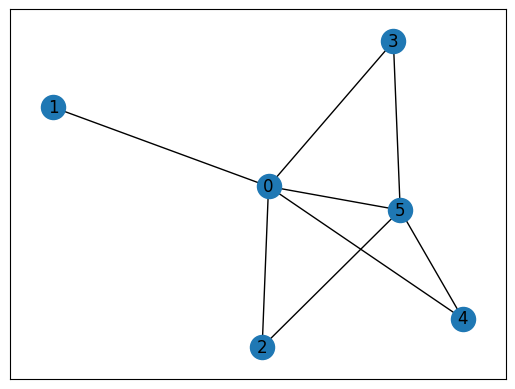

In [ ]:
G1 = nx.watts_strogatz_graph(graph1_size, k = graph1_hyper['k'], p = graph1_hyper['p'])
G2 = nx.barabasi_albert_graph(graph2_size, m = graph2_hyper['m'])

nx.draw_networkx(G1)
plt.show()
print()
nx.draw_networkx(G2)
plt.show()

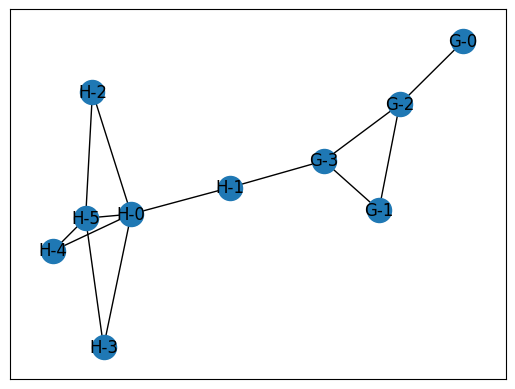

In [ ]:
G_merged = nx.union(G1, G2, rename=("G-", "H-"))
G_merged.add_edge('G-3', 'H-1')

nx.draw_networkx(G_merged)
plt.show()

In [ ]:
W_GT = nx.adjacency_matrix(G_merged).A
weights = np.random.lognormal(0, 0.1, (graph1_size+graph2_size, graph1_size+graph2_size))
weights = (weights + weights.T) / 2
W_GT = W_GT * weights
WW = W_GT

In [ ]:
L_GT = np.diag(W_GT @ np.ones(graph1_size+graph2_size)) - W_GT
W_GT = W_GT * graph1_size / np.sum(W_GT)


W_GT = scipy.sparse.csr_matrix(W_GT)

cov = np.linalg.inv(L_GT + (1e-04) * np.eye(graph1_size+graph2_size))
z = get_distance_halfvector(np.random.multivariate_normal(np.zeros(graph1_size+graph2_size), cov, 4000))

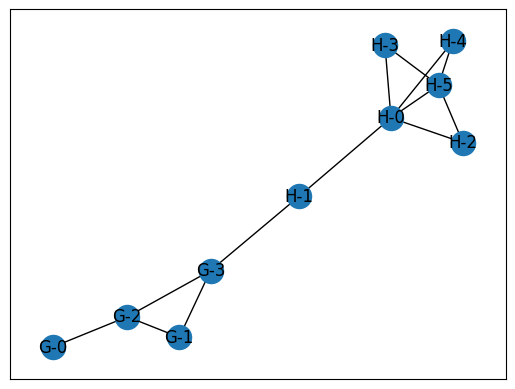

In [ ]:
nx.draw_networkx(G_merged)
plt.show()

In [ ]:
z_ = torch.tensor([z]).float()

In [ ]:
z_ = z_.to(device)
w_list = net.validation(z_ , threshold=1e-04)
w_pred = torch.clamp(w_list[:, num_unroll - 1, :], min=0)

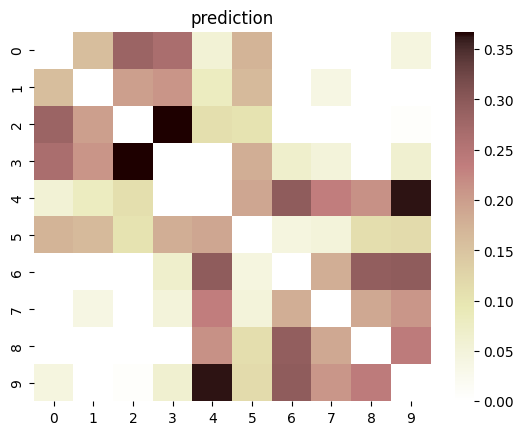

In [ ]:
plt.figure()
sns.heatmap(squareform(w_pred[0].detach().cpu().numpy()), cmap = 'pink_r')
plt.title('prediction')
plt.show()

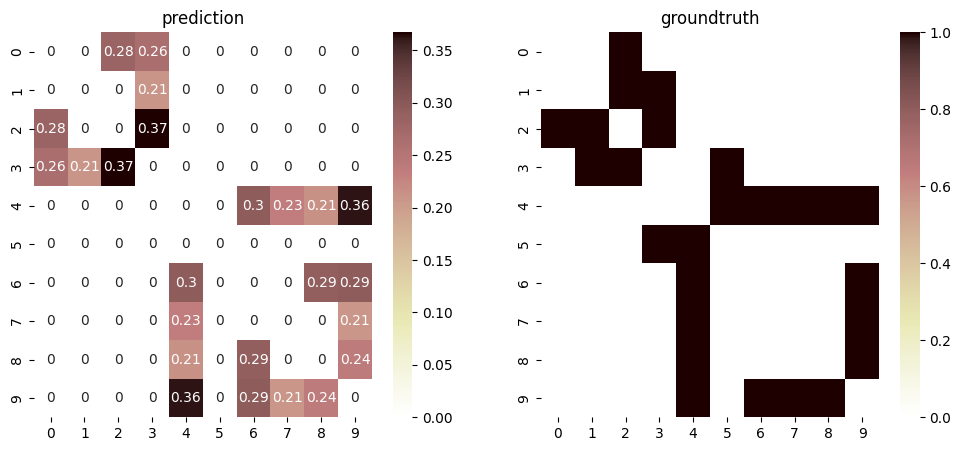

In [ ]:
temp1 = w_pred[0].detach().cpu().numpy()
temp2 = WW
threshold = 0.2

for i in range(len(temp1)):
    if temp1[i]<=threshold:
        temp1[i]=0

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(squareform(temp1), cmap = 'pink_r',  ax=axs[0], annot=True)
axs[0].set_title('prediction')
sns.heatmap(temp2, cmap = 'pink_r', ax=axs[1])
axs[1].set_title('groundtruth')
plt.show()

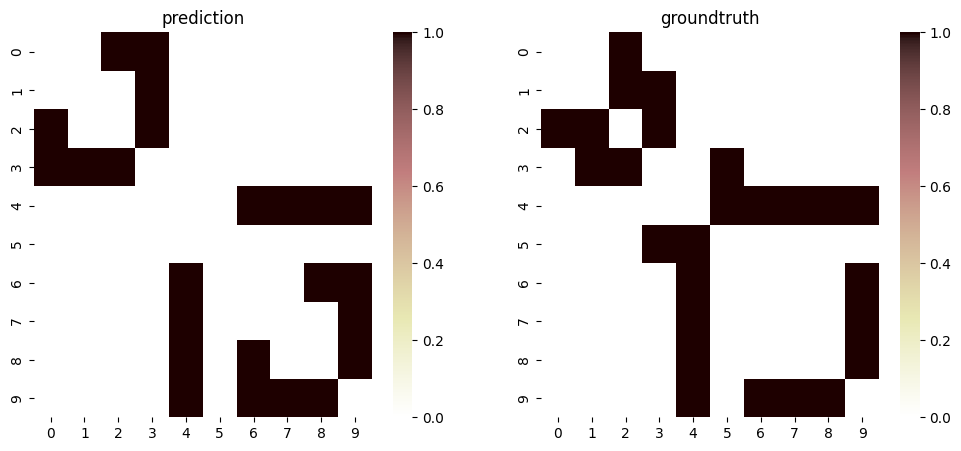

In [ ]:
for i in range(len(temp1)):
    if temp1[i]>=threshold:
        temp1[i]=1

for i in range(len(temp2)):
    for j in range(len(temp2[i])):
        if temp2[i][j]>0:
            temp2[i][j]=1

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(squareform(temp1), cmap = 'pink_r', ax=axs[0])
axs[0].set_title('prediction')
sns.heatmap(temp2, cmap = 'pink_r', ax=axs[1])
axs[1].set_title('groundtruth')
plt.show()

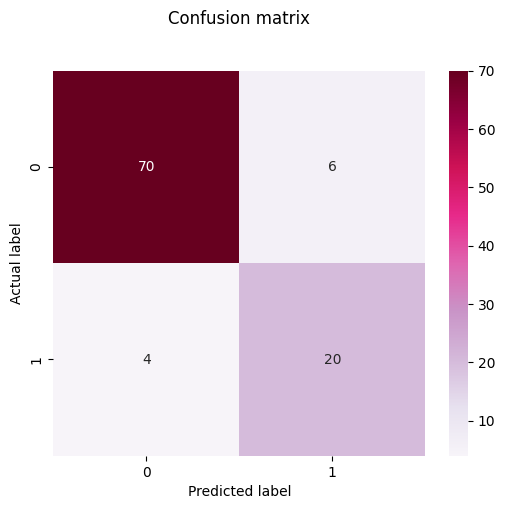

In [ ]:
f, ax = plt.subplots(figsize=(6,5))
cm = confusion_matrix([j for sub in squareform(temp1) for j in sub], [j for sub in temp2 for j in sub])
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="PuRd" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

In [ ]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
FPP = FP/(FP+TN)
FNP = FN/(TP+FN)
ACC = (TP+TN)/(TP+FP+FN+TN)

print('False Positive Proportion: ', FPP)
print('False Negative Proportion: ', FNP)
print('Sensitivity: \t', Sensitivity)
print('Specificity: \t', Specificity)
print('Accuracy: \t', ACC)

False Positive Proportion:  0.07894736842105263
False Negative Proportion:  0.16666666666666666
Sensitivity: 	 0.8333333333333334
Specificity: 	 0.9210526315789473
Accuracy: 	 0.9
